In [0]:
import numpy as np
from scipy.stats import norm
from scipy.spatial import distance

import matplotlib.pyplot as plt

In [0]:
np.random.seed(1)

## Define kernal function (RBF)

In [0]:
def get_kernel_fun(type = 'RBF', **kwargs):
    
    def rbf_kernel(X1,X2):
        '''
        Input: X1 and X2. 
               X1 is n by d, X2 is m by d. 
        Return n by m kernel matrix
        '''
        dist = distance.cdist(X1,X2,metric='euclidean')
        return np.exp(-0.5*dist**2/rbf_param)
    
    rbf_param = kwargs['param']

    return rbf_kernel

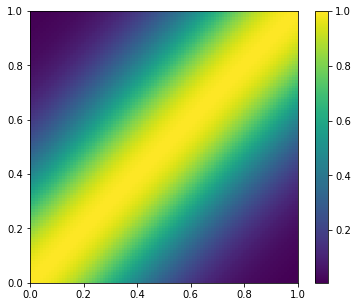

In [4]:
## kernel visualization
kernel = get_kernel_fun(type = 'RBF', param= 0.1)

plt.figure(figsize=(6,5))
x_tmp = np.linspace(0,1,100)
plt.pcolor(x_tmp, x_tmp, kernel(x_tmp.reshape(-1,1), x_tmp.reshape(-1,1)))
plt.colorbar()

## Compute Conditional Distribution

Use $_{0}$ to denote explored spaces, and $_{s}$ for space under search

The join kernel is given as
$K = \begin{pmatrix} K_{ss} & K_{s0}^T \\ K_{0s} & K_{00} \end{pmatrix}$,

where the old kernel is $K_{00}$ ans its cholesky decomposition is as

$K_{00} = LL^T$

The conditional distribution of new $y_s$ follows multivariate gaussian $$\mathcal{N}(\mu_s, \Sigma_s)$$, where

$$ \begin{split} \mu_s & = K_{s0}K_{00}^{-1}y_0 & = K_{s0}(L^{-1})^TL^{-1}y_0 \\
 & = (L^{-1}K_{s0}^T)^TL^{-1}y_0 & = (L^{-1}K_{0s})^TL^{-1}y_0\end{split}$$

 and $$\Sigma_s = K_{ss} - K_{s0}K_{00}^{-1}K{0s} = K_{ss} - K_{s0}(LL^T)^{-1}K_{0s}$$

Let $L_k = L^{-1}K_{0s}$, the above two equations can be written as

$$\mu_s = L_k^TL^{-1}y_0$$, 
$$\Sigma_s = K_{ss} - L_k^TL_k$$

The variance of individual $y$ is the diagonal component of $\Sigma_s$

In [0]:
def get_conditional_dist(x0, y0, xs, kernel_fun):
    '''
    return the mu and standard deviation of conditional distribution of ys at xs given y0 at xs
    p(ys|y0)
    '''

    K00 = kernel_fun(x0, x0)
    Kss = kernel_fun(xs, xs)
    K0s = kernel_fun(x0, xs)
    
    L = np.linalg.cholesky(K00 + 1e-3*np.eye(K00.shape[0]))
    #solve mu of xs conditional at x0,y0
    Lk = np.linalg.solve(L, K0s)
    mu_s = np.dot(Lk.T, np.linalg.solve(L,y0))

    #solve variance on xs conditional at x0,y0
    var_s = np.diag(Kss) - np.sum(Lk**2, axis=0)
    sigma_s = np.sqrt(var_s)

    return mu_s, sigma_s

## Define acquisition functions
Given expected mean and variance, return an aggregated value

In [0]:
def get_score_fun(ftype = 'exploration_exploitation', **kwargs):
    '''
    ftype 
       exploration_exploitation: mu+kappa*sigma, kappa should be passed
       improvement_probability : probability of improvment. bestY value so far must be passed
       
    '''
    def exploration_exploitation_fun(mu, sigma, y):
        return mu+sigma*kappa

    def prob_improvement(mu, sigma, y):
        bestY = y.max()
        return norm.cdf((mu-bestY-xi)/sigma)
    
    def expected_improvement(mu, sigma, y):
        bestY = y.max()
        Z = (mu-bestY-xi)/sigma
        EI = (Z*norm.cdf(Z)+norm.pdf(Z))*sigma
        return EI 
    
    kappa = kwargs['kappa'] if 'kappa' in kwargs else 1
    xi = kwargs['xi'] if 'xi' in kwargs else 0.1    

    if ftype=='exploration_exploitation':
        return exploration_exploitation_fun
    elif ftype == 'improvement_probability':
        return prob_improvement
    elif ftype == 'expected_improvement':
        return expected_improvement

## Bayesian Optimization Workflow

In [0]:
def plot_progress(x_true, y_true, x0, y0, x, mu, sigma, score, xs, ys, verbose):
    d = x.shape[1]
    score = (score-score.min())/(score.max()-score.min()+1e-6)
        
    if d==1:
        xt, yt = x_true.flatten(), y_true.flatten()
        isort = xt.argsort()
        xt, yt = xt[isort], yt[isort]

        ylim = [min(yt.min()-1,-2),yt.max()+1]

        plt.plot(xt, yt,'--',label='truth')
        plt.plot(x0, y0,'.', markersize=15, label='x0')
        plt.plot(xs, ys,'g.', markersize=15, label='xs')
        plt.plot([xs,xs], ylim,'g--')

        #scale score
        x = x.flatten()
        isort = x.argsort()
        x, mu, sigma, score = x[isort], mu[isort], sigma[isort], score[isort]

        plt.plot(x, score-2, label='score')
        plt.fill_between(x, mu-2*sigma, mu+2*sigma, color = '#dddddd')

        plt.ylim(ylim)

    elif d==2:
        plt.tricontourf(x[:,0], x[:,1], score, 10, cmap='ocean',alpha= 0.4)
        plt.tricontour(x_true[:,0], x_true[:,1], y_true, 10, cmap = 'jet', linewidths=1)
        plt.scatter(x0[:,0],x0[:,1], s= 30, c='#EEFF00', label='x0')
        plt.scatter(xs[0], xs[1], s = 50, c='g', label='xs')
        plt.xlim([x_true[:,0].min()-0.25, x_true[:,0].max()+0.25])
        plt.ylim([x_true[:,1].min()-0.25, x_true[:,1].max()+0.25])

    if verbose:
        plt.legend()


In [0]:
def sample_x(x_range, n, method = 'random'):
    '''
    given x_range (d by 2) array, sample points in the d-dim space within the range
    method:
        random: uniformly random sample
        linear: linearly sample. In this case, n is the number of grid along each dimension
    '''
    x_range = np.asarray(x_range)
    if len(x_range.shape)==1:
        x_range = np.expand_dims(x_range, axis=0)

    d = x_range.shape[0]
    if method =='random':
        return np.random.rand(n, d)*np.ptp(x_range,axis=1) + x_range.min(axis=1)

    elif method == 'linear':
        x_per_dim = [np.linspace(r[0],r[1],n) for r in x_range]
        grids = np.meshgrid(*x_per_dim)
        grids = np.array([grid.flatten() for grid in grids]).T
        return grids

In [0]:
def bayesianOpt(f, kernel_fun, score_fun, x_range, x0 = None, init_n = 5, n_iter = 10, n_sample_per_iter = 100, verbose = True):
    '''
    f: function to optimize
    kernel_fun: function to compute kernel
    score_fun: function to compute score given estimated mu, std, and known y so far
    x_range: search range along each dimension. x_range is d by 2 numpy array
    x_0: initial guess (optional)
    n_sample_per_iter: number of point to sample per iteration (optional)
    init_n: if initial guess is not provided, randomly sample init_n from the given range
    n_iter: number of iteration
    '''
    if verbose:
        n_col = min(5,int(1+np.ceil(np.sqrt(n_iter))))
        n_row = int(np.ceil(n_iter/n_col))
        plt.figure(figsize=(20,18/n_col*n_row))
        
        ## ground truth example
        x_true = sample_x(x_range, 100, method = 'linear')
        y_true = f(x_true)
        print(f'Naive scan found max y={y_true.max():.4f}')

    ## 1. Init with several exploration
    if x0 is None:
        x0 = sample_x(x_range, init_n, method = 'random')
    y0 = f(x0)

    for i in range(n_iter):
        # get candidate
        #x_candidate = np.linspace(x_range[0],x_range[1], 100)
        #x_candidate = np.sort(np.random.rand(100,1)*(x_range[1]-x_range[0])+x_range[0])
        x_candidate = sample_x(x_range, n_sample_per_iter)
        #x_candidate = np.setdiff1d(x_candidate, x0) # remove explored points

        #estimate conditional distribution
        mu, sigma = get_conditional_dist(x0, y0, x_candidate, kernel_fun)

        #get score
        score = score_fun(mu,sigma, y0)

        #select xs that gives highest score
        ind_select = np.argmax(score)
        xs = x_candidate[ind_select]

        #evaluate at xs
        ys = f(xs)

        #append to explored data
        x0 = np.vstack((x0,xs))
        y0 = np.append(y0,ys)

        if verbose:
            plt.subplot(n_row,n_col,i+1)
            plot_progress(x_true, y_true, x0, y0, x_candidate, mu, sigma, score, xs, ys, True if i==0 else False)
            plt.title(f'Iter - {i+1}, best y={y0.max():.4f}')
    
    if verbose:
        print(f'Best solution found by Bayesian Optimizer {y0.max()}')

    return y0.max()

    

## Experiment with different search scenarios
---

#### define function

In [0]:
def fun1(x):
    y = np.cos(x)*np.sin(10*x)+np.exp(-(x-1.0)**2*50.0)*2.0
    return y.flatten()

def fun2(x):
    y = x*np.cos(10*x)+np.exp(-(x-0.5)**2*200.0)*2.0
    return y.flatten()

#### 1. Search with $\mu+2\sigma$ acquisition function and $\rho=0.05$ 

Naive scan found max y=1.7582
Best solution found by Bayesian Optimizer 1.7592703662952085


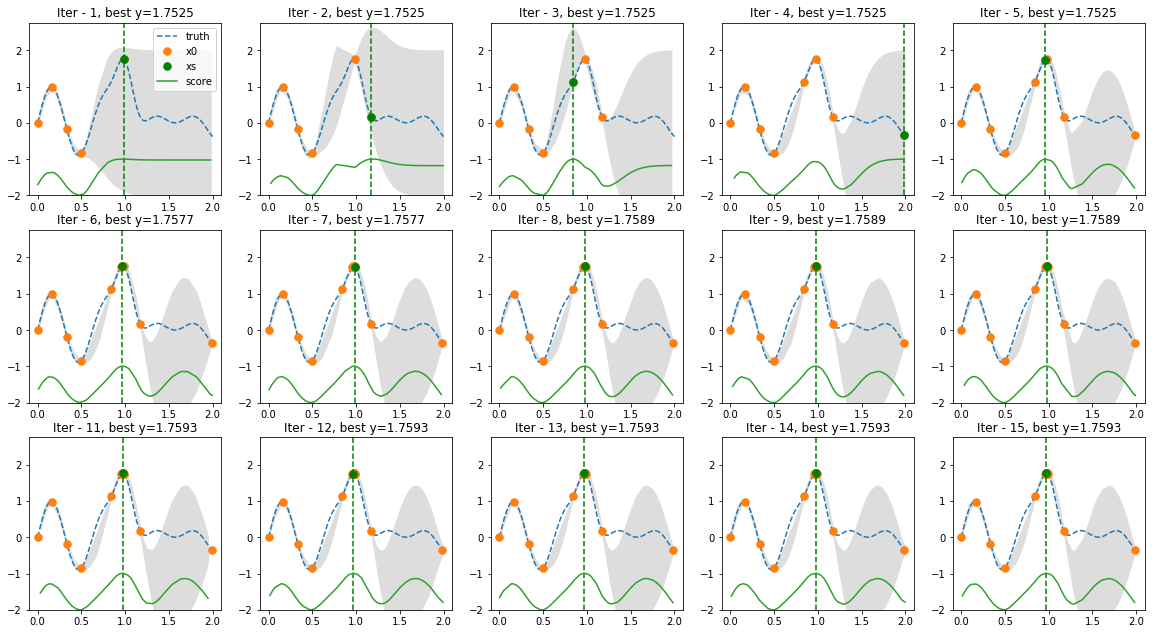

In [11]:
x0 = sample_x([0,0.5],4,'linear')

## get acquisition function
score_fun = get_score_fun(ftype = 'exploration_exploitation', kappa = 2) #bigger kappa means more exploration
## get kernel function
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(fun1, kernel_fun, score_fun, x_range = [0,2], x0 = x0, n_iter=15)

#### 2. Search with $\mu+0.5\sigma$ acquisition function and $\rho=0.05$ (less exploration)

Naive scan found max y=1.7582
Best solution found by Bayesian Optimizer 0.987640607958829


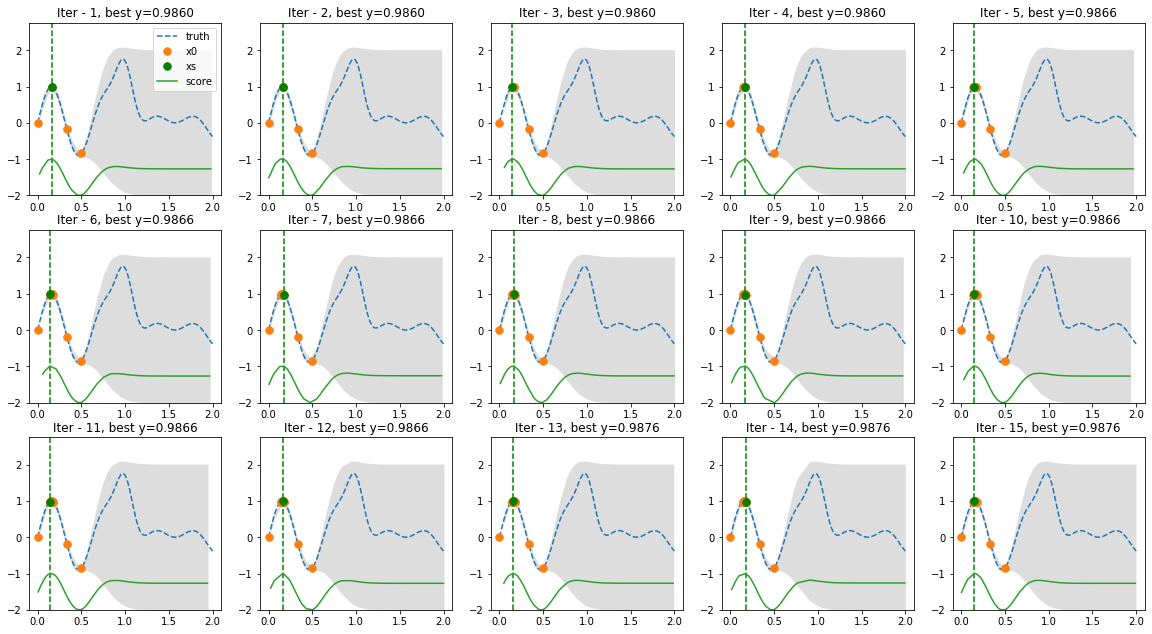

In [12]:
score_fun = get_score_fun(ftype = 'exploration_exploitation', kappa = 0.5) #bigger kappa means more exploration
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(fun1, kernel_fun, score_fun, x_range = [0,2],  x0 = x0, n_iter=15)

#### 3. Search with $\mu+2\sigma$ acquisition function and $\rho=0.01$ (less belief on function smoothness)



Naive scan found max y=1.7582
Best solution found by Bayesian Optimizer 1.7476438195524628


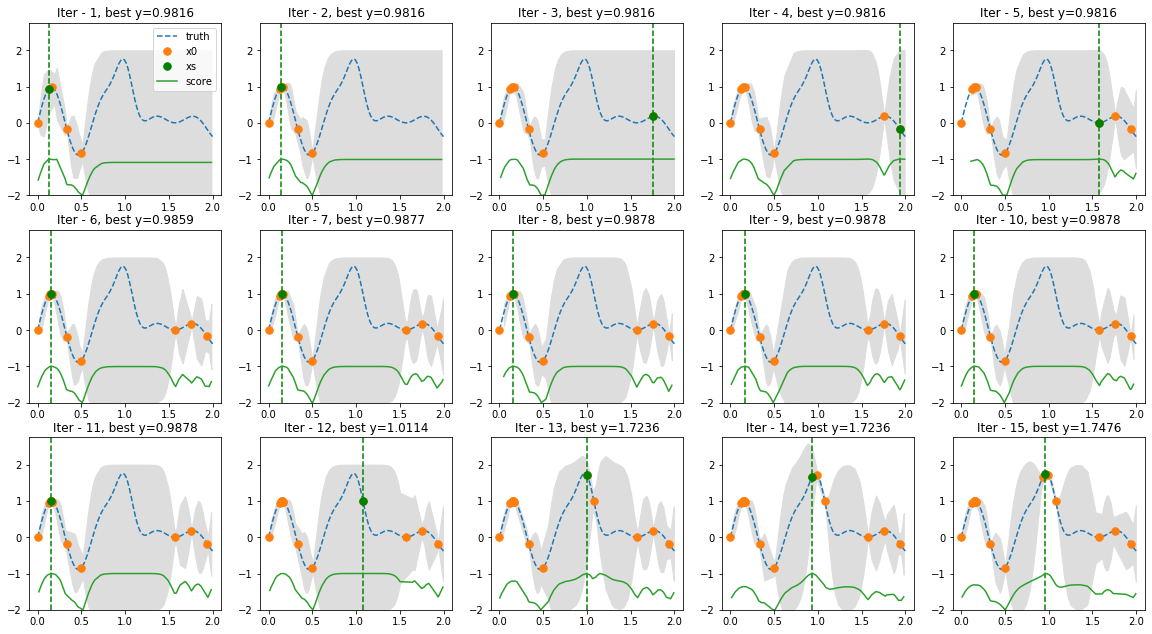

In [13]:
score_fun = get_score_fun(ftype = 'exploration_exploitation', kappa = 1) #bigger kappa means more exploration
kernel_fun = get_kernel_fun('RBF',param = 0.01)

y_max = bayesianOpt(fun1, kernel_fun, score_fun, x_range = [0,2], x0 = x0, n_iter=15)

#### 4. Search with improvement probability acquisition function and $\rho=0.05$

Naive scan found max y=1.7582
Best solution found by Bayesian Optimizer 1.7555208934612159


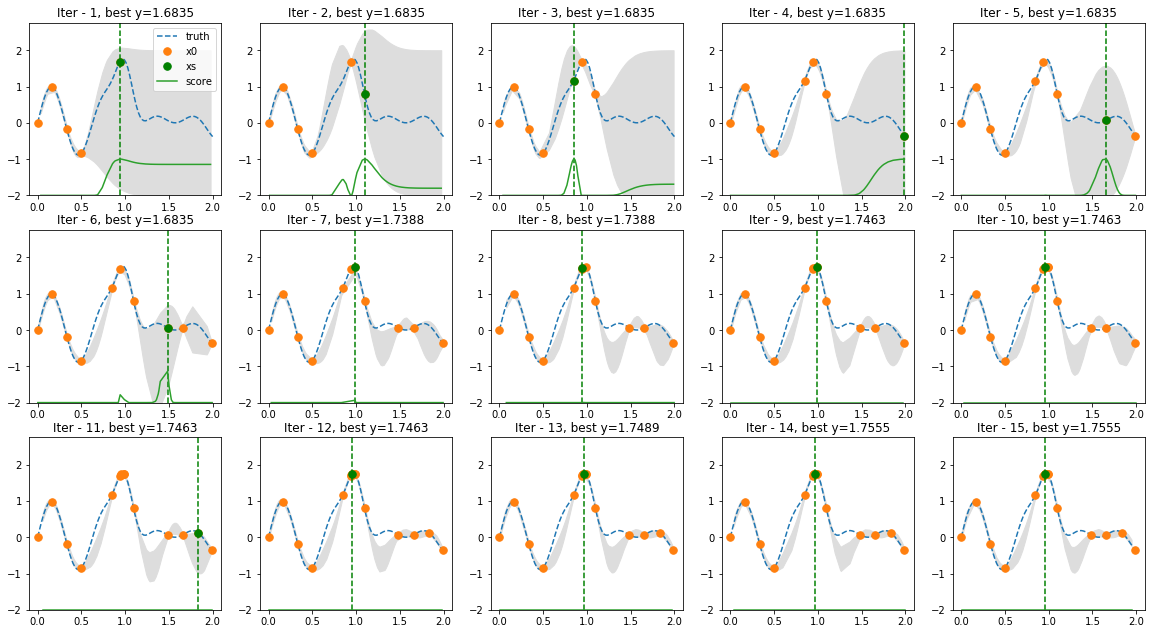

In [14]:
#score_fun = get_score_fun(ftype = 'improvement_probability') # select candidate based on which one has the largest probability of beating the best solution so far
score_fun = get_score_fun(ftype = 'expected_improvement') # select candidate based on which one has the largest probability of beating the best solution so far
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(fun1, kernel_fun, score_fun, x_range = [0,2], x0=x0, n_iter=15)

#### 5. Try a different function

Naive scan found max y=2.1574
Best solution found by Bayesian Optimizer 2.0710310615361527


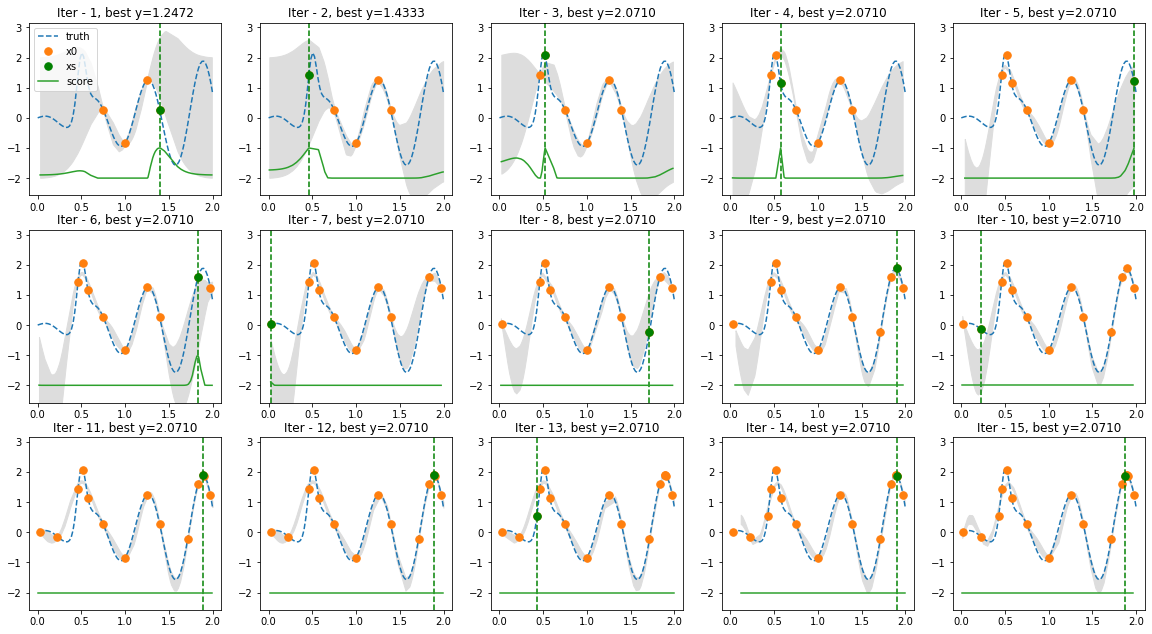

In [15]:
x0 = sample_x([0.75,1.25],3,'linear')
score_fun = get_score_fun(ftype = 'expected_improvement') # select candidate based on which one has the largest probability of beating the best solution so far
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(fun2, kernel_fun, score_fun, x_range = [0,2], x0 = x0, n_iter=15)

### 6. 2D function

In [0]:
def fun2d(X):
    if (len(X.shape)==1):
        X = np.expand_dims(X,axis=0)
    x, y = X[:,0], X[:,1]
    r = x**2 + y**2
    z = np.sin(r*5)*np.exp(-r*2)
    return z

def Rosenbrock(X):
    if (len(X.shape)==1):
        X = np.expand_dims(X,axis=0)
    a = 0.5
    b = 5
    x, y = X[:,0], X[:,1]
    
    z = (a-x)**2 + b*(y-x**2)**2
    return -z

def Booth(X):
    if (len(X.shape)==1):
        X = np.expand_dims(X,axis=0)
    x, y = X[:,0], X[:,1]
    z = (x+2*y-7)**2 + (2*x+y-5)**2
    return -z

Naive scan found max y=0.5768
Best solution found by Bayesian Optimizer 0.5759806700744511


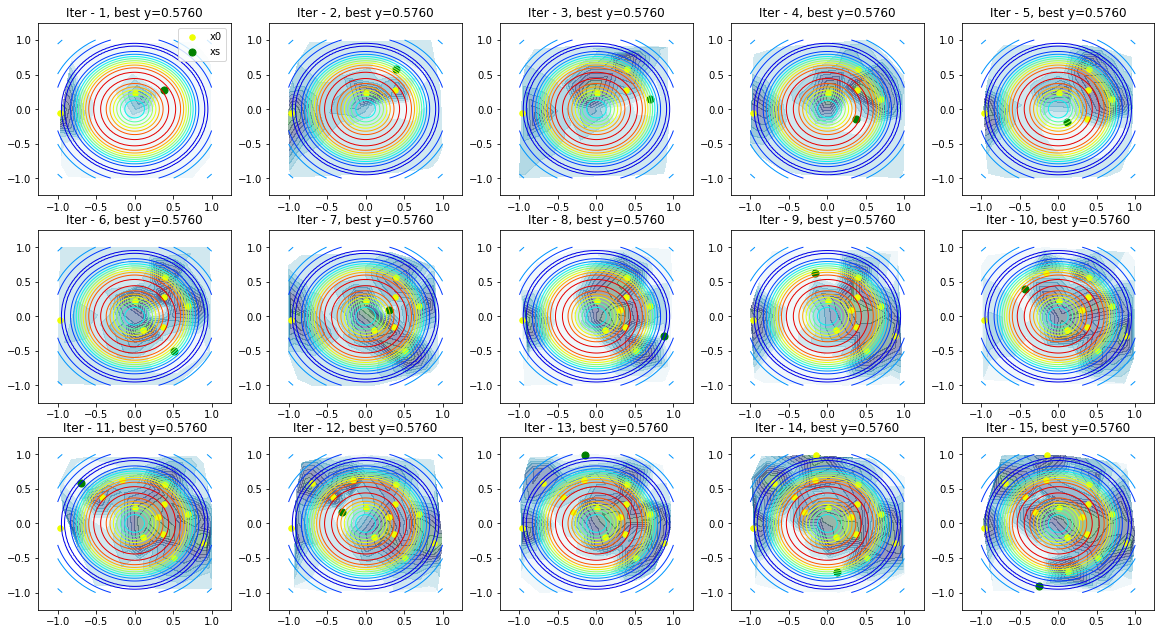

In [27]:
x_range = [[-1,1],[-1,1]]
x0 = sample_x(x_range, 2)

score_fun = get_score_fun(ftype = 'expected_improvement') # select candidate based on which one has the largest probability of beating the best solution so far
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(fun2d, kernel_fun, score_fun, x_range = x_range, x0 = x0, n_iter=15, n_sample_per_iter = 100)

Naive scan found max y=-0.0003
Best solution found by Bayesian Optimizer -0.013121568166945301


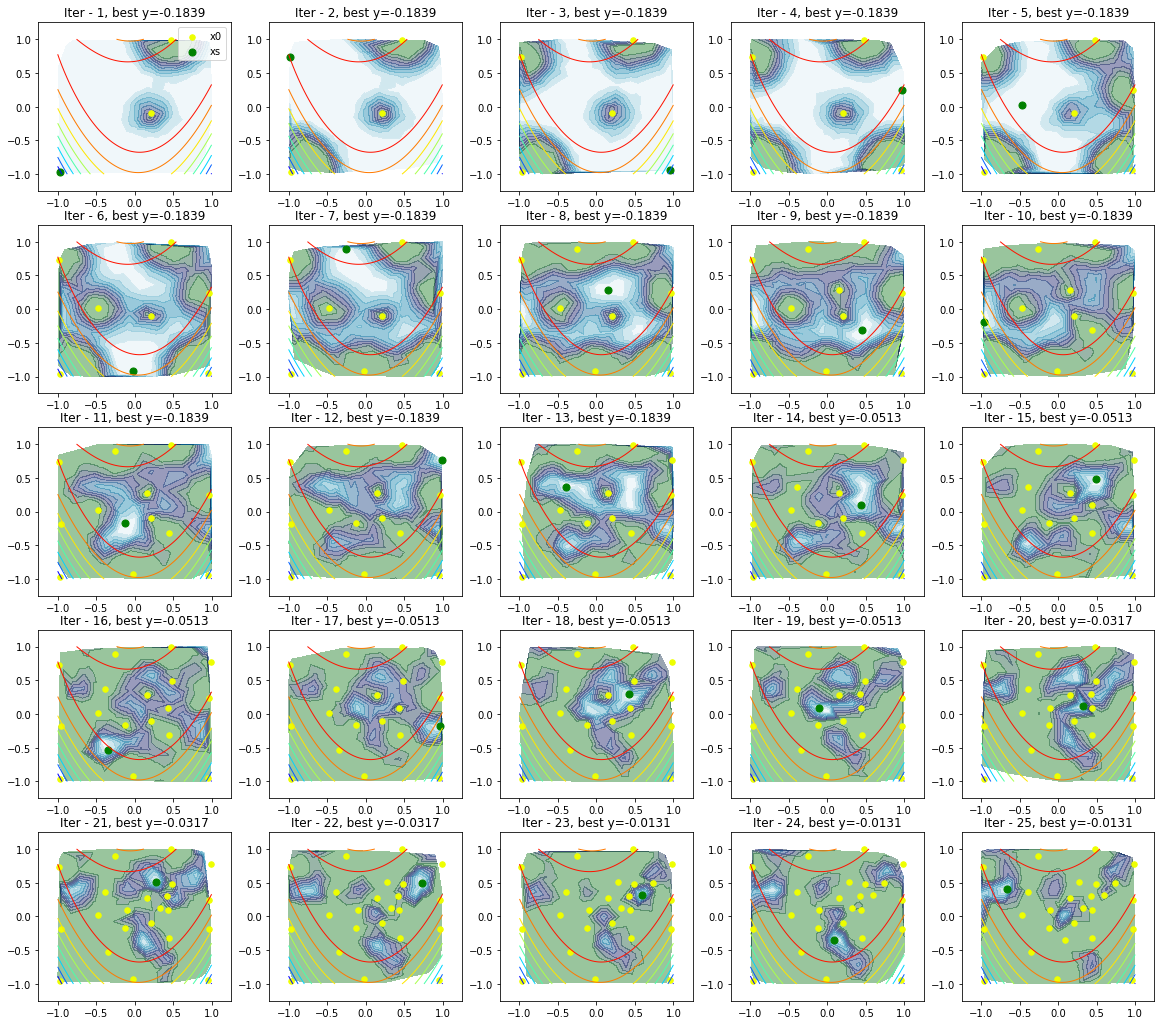

In [28]:
x_range = [[-1,1],[-1,1]]
x0 = sample_x(x_range, 2)

score_fun = get_score_fun(ftype = 'expected_improvement') # select candidate based on which one has the largest probability of beating the best solution so far
kernel_fun = get_kernel_fun('RBF',param = 0.05)

y_max = bayesianOpt(Rosenbrock, kernel_fun, score_fun, x_range = x_range, x0 = x0, n_iter=25, n_sample_per_iter = 250)

Naive scan found max y=-0.0008
Best solution found by Bayesian Optimizer -0.011411654204657637


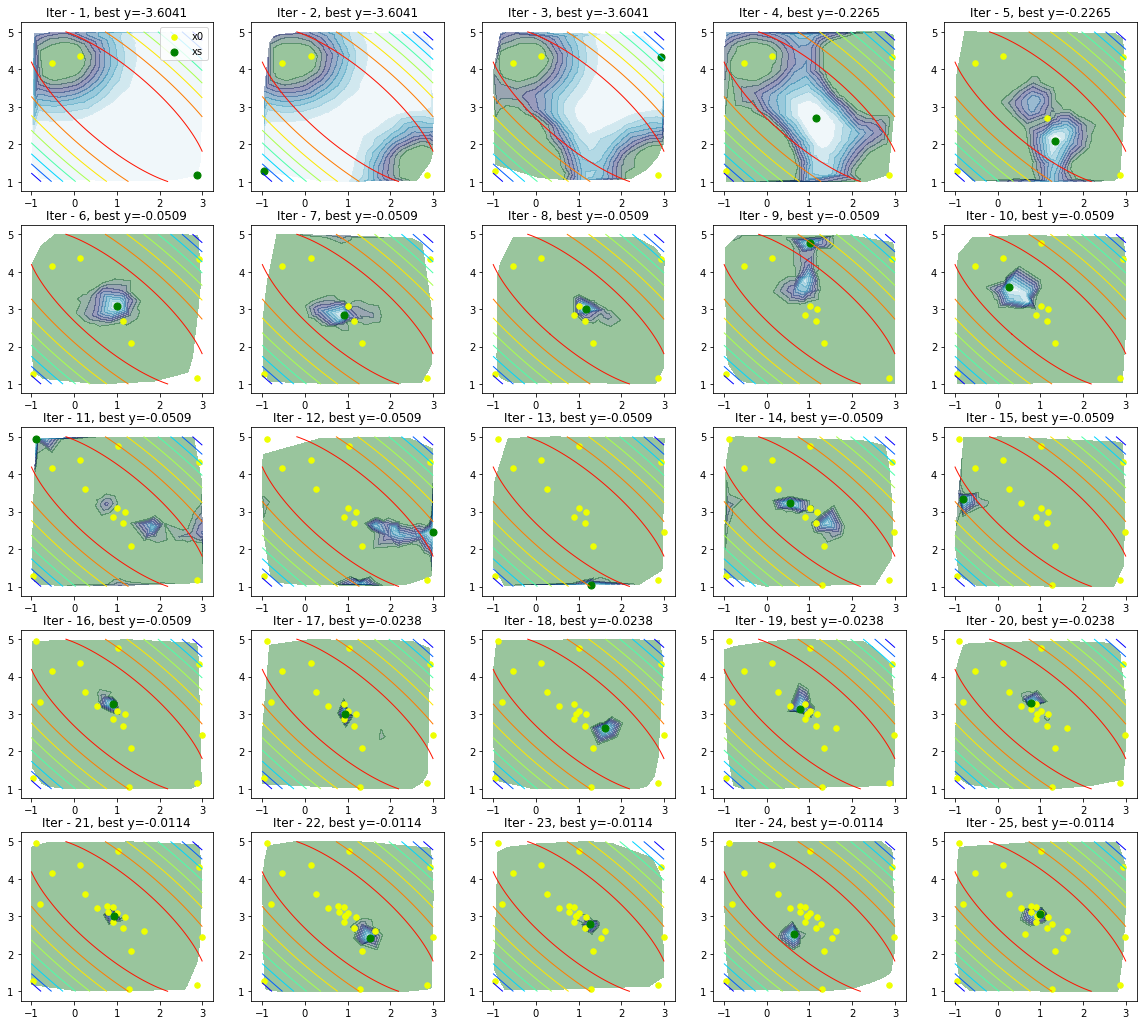

In [29]:
x_range = [[-1,3],[1,5]]
x0 = sample_x(x_range, 2)

score_fun = get_score_fun(ftype = 'expected_improvement') # select candidate based on which one has the largest probability of beating the best solution so far
kernel_fun = get_kernel_fun('RBF',param = 0.5)

y_max = bayesianOpt(Booth, kernel_fun, score_fun, x_range = x_range, x0 = x0, n_iter=25, n_sample_per_iter = 250)